In [ ]:
# pip install tensorflow matplotlib scikit-learn keras-tuner keras

In [1]:
import gc

import tensorflow as tf
%matplotlib inline

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband

import matplotlib.pyplot as plt
import numpy as np

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.16.1


/var/folders/dp/w8c9sz4j6rxbq418ktj26ycr0000gn/T/ipykernel_31000/2058656791.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

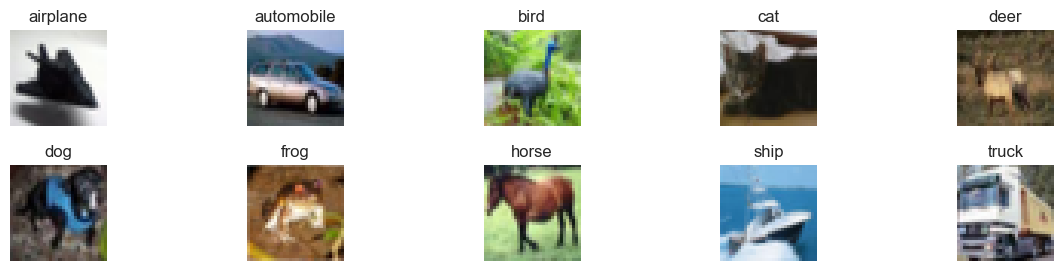

Number of unique classes in the CIFAR-10 dataset:  10


In [4]:
unique_classes = np.unique(y_train)
unique_classes_len = len(unique_classes)

unique_classes, first_occurrence_indices = np.unique(y_train, return_index=True)

# Normalize pixel values to be between 0 and 1 for display
x_train_normalized = x_train / 255.0

# Display one image from each class with class names in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 3))  # Adjust the figsize as needed
for i, idx in enumerate(first_occurrence_indices):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(x_train_normalized[idx])
    axs[row, col].axis('off')
    axs[row, col].set_title(class_names[unique_classes[i]])

plt.subplots_adjust(hspace=0.4, wspace=0.1)  # Increase hspace and decrease wspace as needed
plt.show()

print("Number of unique classes in the CIFAR-10 dataset: ", unique_classes_len)

In [5]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (for use with categorical_crossentropy)
y_train = to_categorical(y_train, unique_classes_len)
y_test = to_categorical(y_test, unique_classes_len)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [6]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


In [7]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

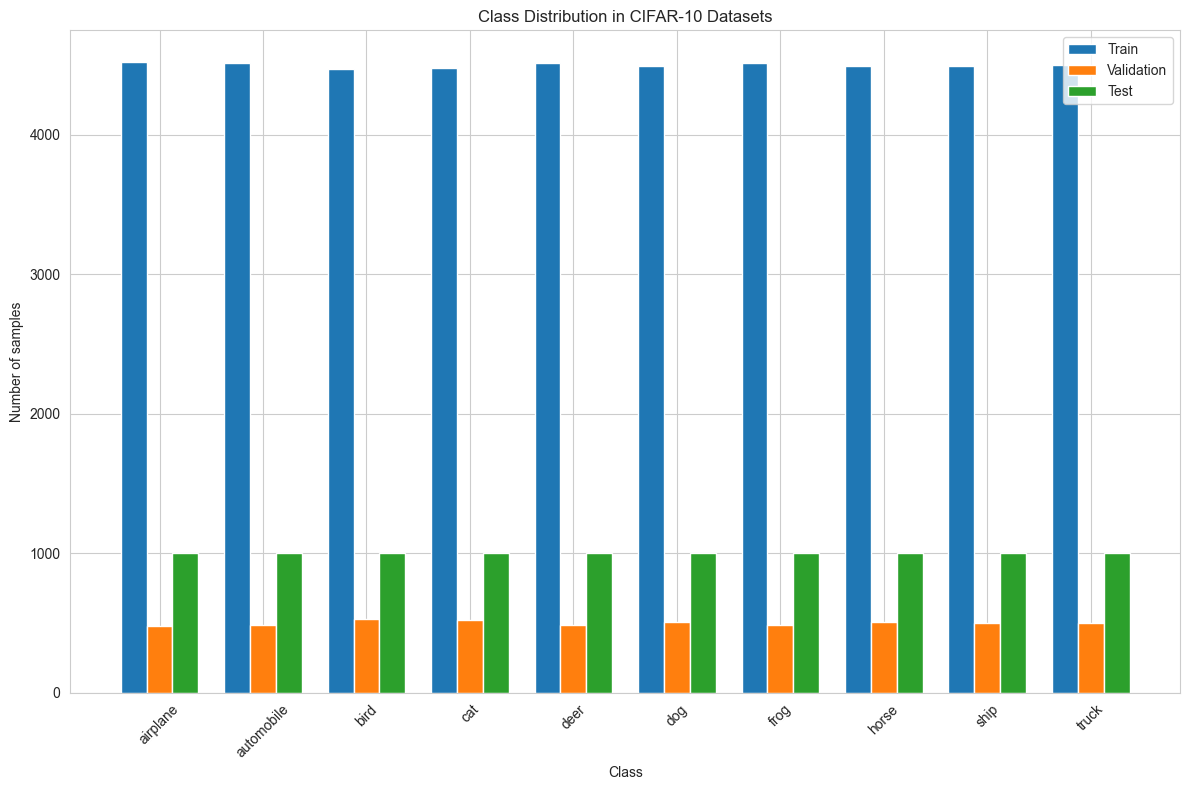

In [8]:
# Function to calculate class distribution
def calculate_class_distribution(y_dataset):
    # Since the labels are one-hot encoded, summing them will give us the count per class
    class_distribution = np.sum(y_dataset, axis=0)
    return class_distribution

# Calculate class distributions
train_class_distribution = calculate_class_distribution(y_train)
val_class_distribution = calculate_class_distribution(y_val)
test_class_distribution = calculate_class_distribution(y_test)

# Plotting the distributions
def plot_class_distribution(train_dist, val_dist, test_dist, unique_classes_len):
    fig, ax = plt.subplots(figsize=(12, 8))
    index = np.arange(unique_classes_len)
    bar_width = 0.25

    # Plot each distribution with an offset for the bar position
    plt.bar(index, train_dist, bar_width, label='Train')
    plt.bar(index + bar_width, val_dist, bar_width, label='Validation')
    plt.bar(index + 2 * bar_width, test_dist, bar_width, label='Test')

    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class Distribution in CIFAR-10 Datasets')
    plt.xticks(index + bar_width, class_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_class_distribution(train_class_distribution, val_class_distribution, test_class_distribution, unique_classes_len)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),  # Add Dropout

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),  # Add Batch Normalization
    MaxPooling2D(2, 2),
    Dropout(0.3),  # Increase dropout rate to prevent overfitting

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),  # Add Batch Normalization
    MaxPooling2D(2, 2),
    Dropout(0.4),  # Further increase dropout rate for deeper layers


    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Use 'softmax' for categorical
])



/Users/antonal/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for categorical
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,930 (1.38 MB)

 Trainable params: 361,482 (1.38 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
epochs = 20  # Start with a small number of epochs and adjust based on your results
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64,
                    validation_data=(x_val, y_val))

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.3082 - loss: 2.1004 - val_accuracy: 0.3440 - val_loss: 2.3953
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.4821 - loss: 1.4311 - val_accuracy: 0.5106 - val_loss: 1.4030
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.5434 - loss: 1.2773 - val_accuracy: 0.6266 - val_loss: 1.0421
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.5763 - loss: 1.1959 - val_accuracy: 0.5220 - val_loss: 1.4505
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.6030 - loss: 1.1223 - val_accuracy: 0.6252 - val_loss: 1.0412
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6271 - loss: 1.0530 - val_accuracy: 0.6254 - val_loss: 1.0301
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.6427 - loss: 1.0162 - val_accuracy: 0.6684 - val_loss: 0.9195
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.6506 - loss: 0.9990 - 

In [13]:
history_eval = model.evaluate(x_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6908 - loss: 0.9120


In [14]:
clean_up(model)

Train Loss     : 0.78401
Validation Loss: 0.88835
Test Loss      : 0.91446
---
Train Accuracy     : 0.72720
Validation Accuracy: 0.68920
Test Accuracy      : 0.68810



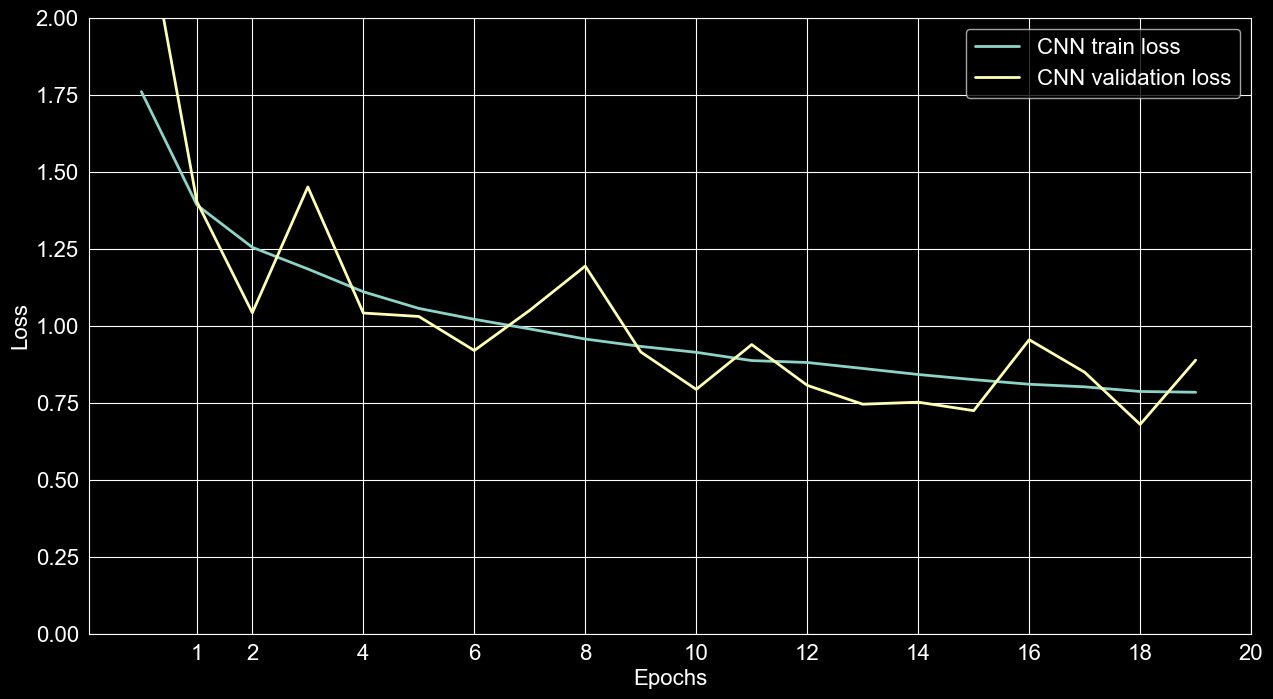

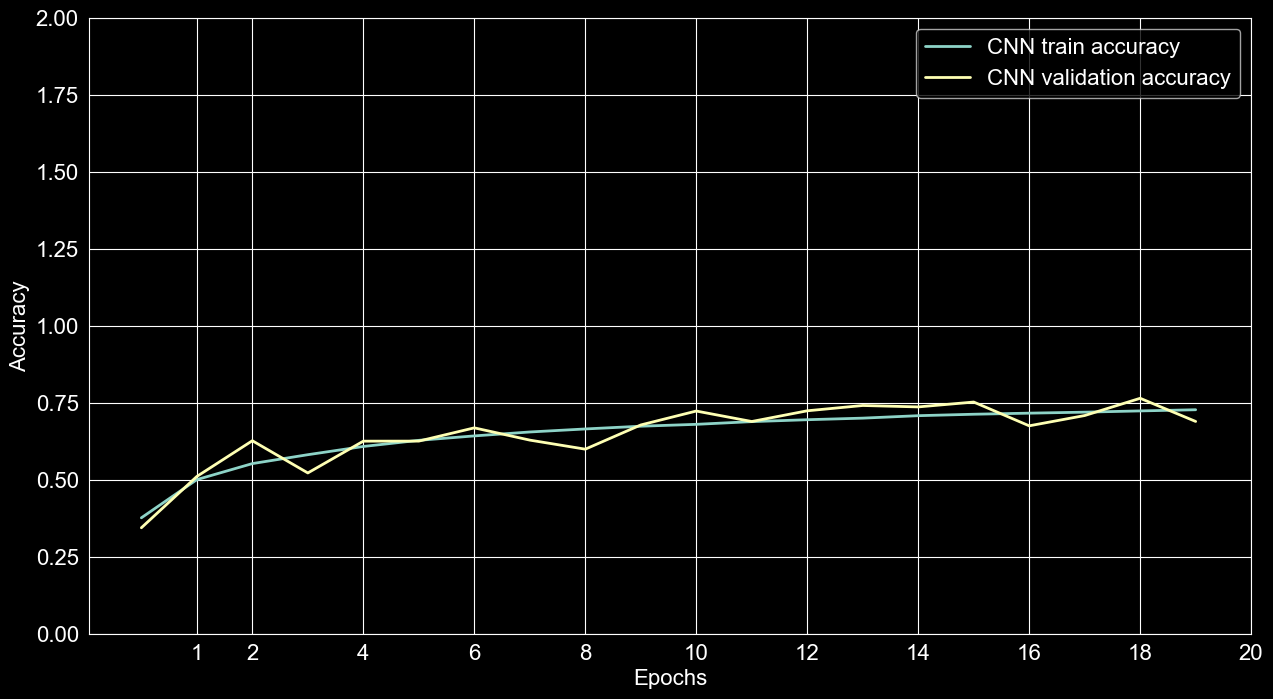

In [15]:
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(history_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(history_eval[1]))

# Plot train and validation error per epoch.
plot_history(hs={'CNN': history}, epochs=20, metric='loss')
plot_history(hs={'CNN': history}, epochs=20, metric='accuracy')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


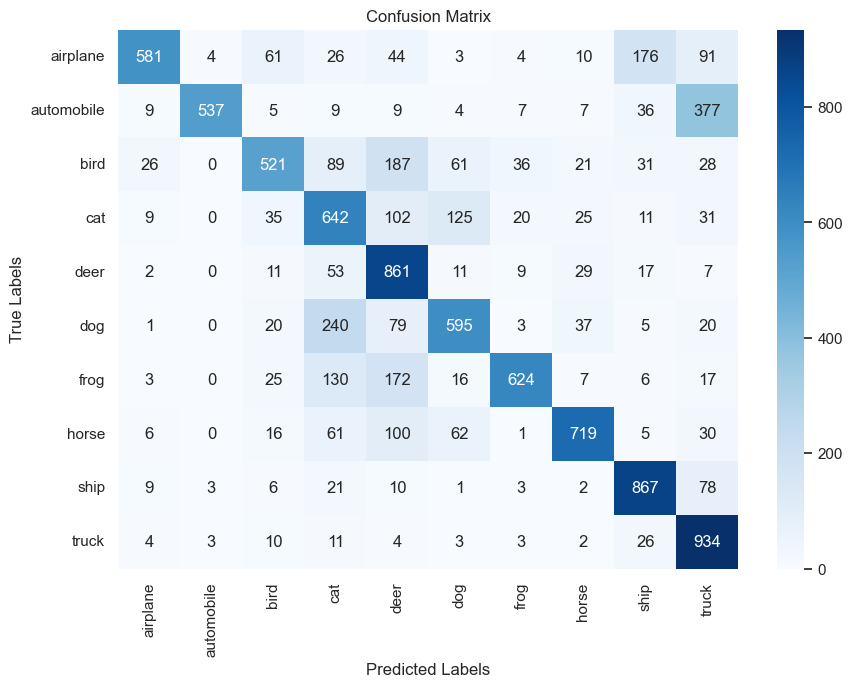

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `predictions` are the raw outputs from your model, e.g., softmax probabilities
# Convert predictions and true labels from one-hot encoded to class indices
predictions = np.argmax(model.predict(x_test), axis=-1)
y_test_indices = np.argmax(y_test, axis=-1)  # Only if y_test is one-hot encoded

sns.set_theme(style="white")
# Calculate the confusion matrix
cm = confusion_matrix(y_test_indices, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming your model's prediction function returns the class probabilities
predictions_prob = model.predict(x_test)  # Get model predictions for the test set

# Convert probabilities to predicted class labels
predictions = np.argmax(predictions_prob, axis=1)

# Assuming y_test is one-hot encoded, convert it to single integer labels
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, predictions, target_names=class_names)

print(report)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

    airplane       0.89      0.58      0.70      1000
  automobile       0.98      0.54      0.69      1000
        bird       0.73      0.52      0.61      1000
         cat       0.50      0.64      0.56      1000
        deer       0.55      0.86      0.67      1000
         dog       0.68      0.59      0.63      1000
        frog       0.88      0.62      0.73      1000
       horse       0.84      0.72      0.77      1000
        ship       0.73      0.87      0.80      1000
       truck       0.58      0.93      0.71      1000

    accuracy                           0.69     10000
   macro avg       0.74      0.69      0.69     10000
weighted avg       0.74      0.69      0.69     10000



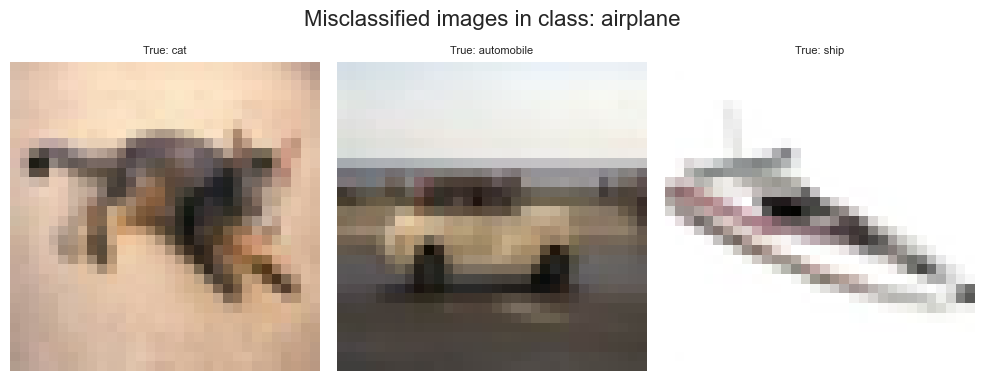

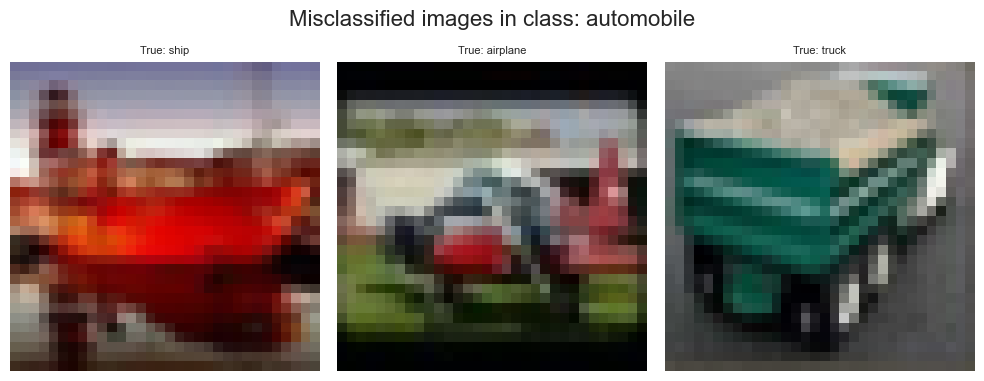

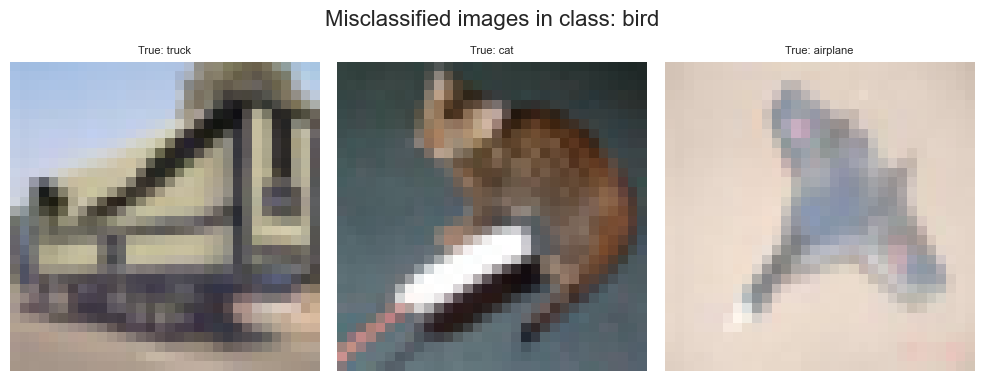

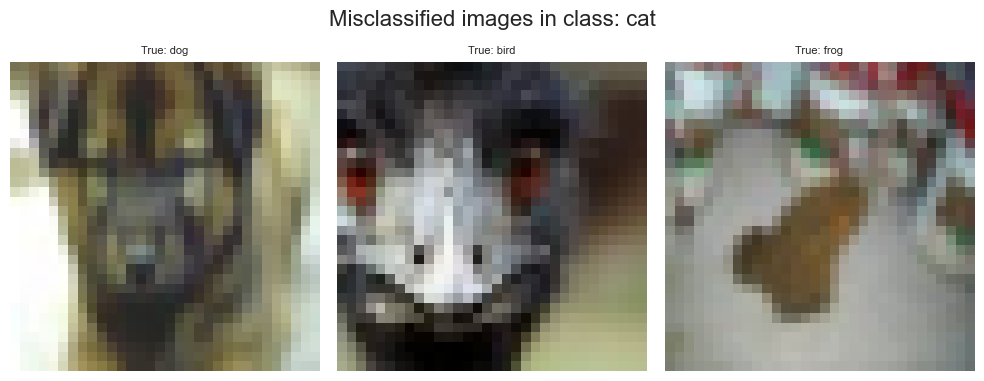

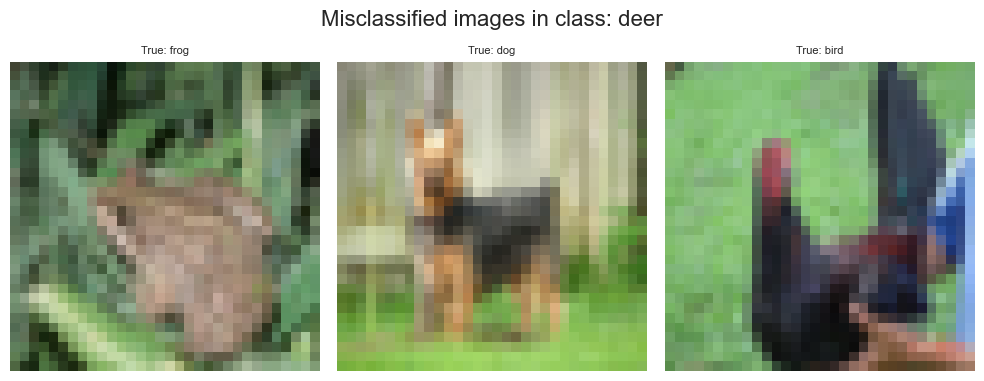

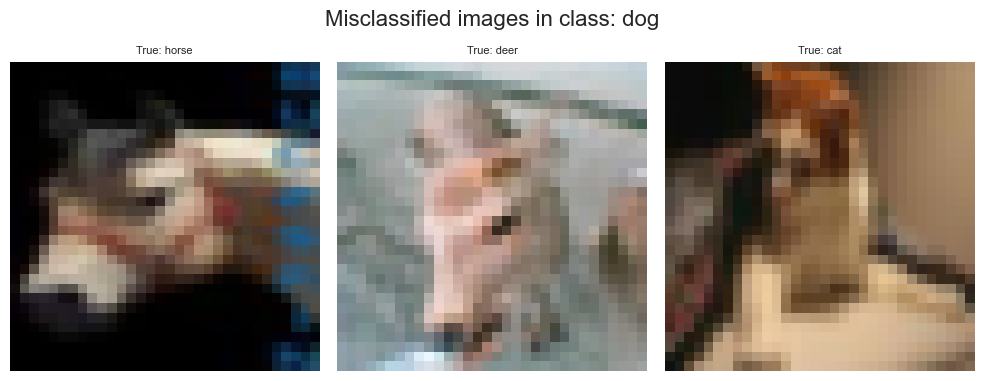

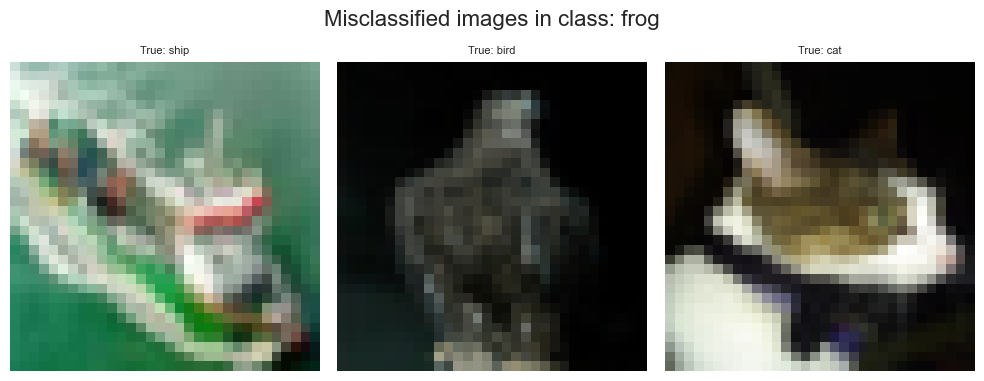

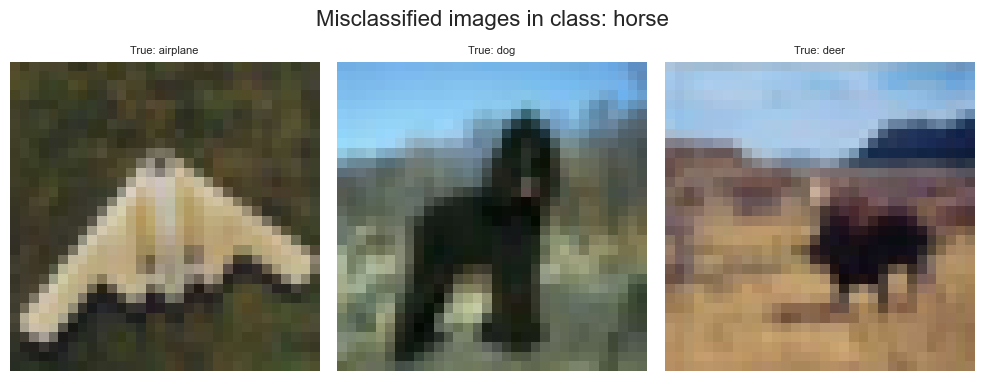

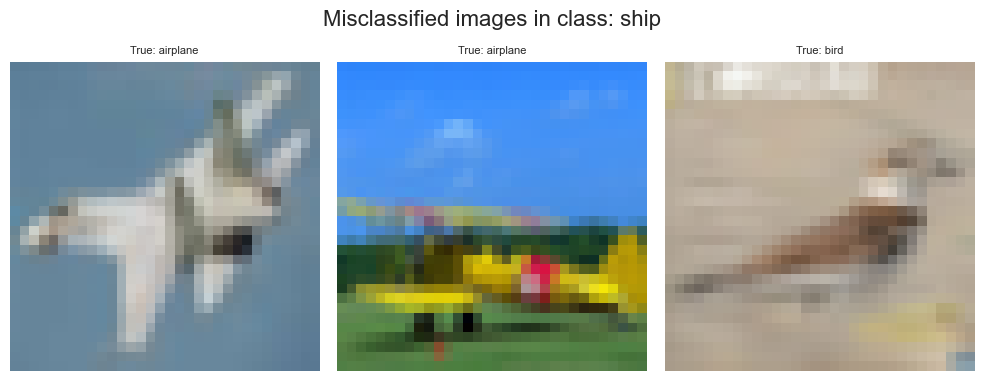

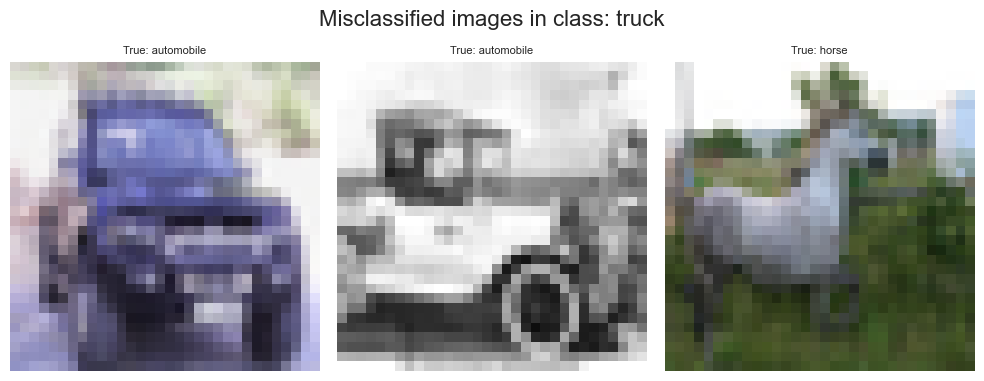

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming predictions_prob is your model's probability predictions,
# and y_test is the one-hot encoded true labels
predictions = np.argmax(predictions_prob, axis=1)
y_test_class_indices = np.argmax(y_test, axis=1)

def plot_images(images, titles, class_name, nrows=1, ncols=3):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4))
    fig.suptitle(f"Misclassified images in class: {class_name}", fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # No cmap parameter needed for color images
            ax.imshow(images[i])
            ax.set_title(titles[i], fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

for pred_class_idx, pred_class_name in enumerate(class_names):
    # Find indices where the prediction was pred_class_idx but the true class was different
    misclassified_indices = np.where((predictions == pred_class_idx) &
                                     (y_test_class_indices != pred_class_idx))[0]

    # Select a subset of misclassified images for this predicted class
    subset_indices = misclassified_indices[:3]  # Adjust the number of images as needed

    if len(subset_indices) > 0:
        images = [x_test[i].reshape(32, 32, 3) for i in subset_indices]
        titles = [f"True: {class_names[y_test_class_indices[i]]}" for i in subset_indices]

        plot_images(images, titles, pred_class_name)




## Hyperparameter Tuning

In [54]:
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.random import set_seed

def build_model(layer_configs, optimizer):
    """
    Build a customizable CNN model based on provided layer configurations.

    :param layer_configs: A list of dictionaries, each specifying configurations for a Conv2D layer and its associated components like BatchNormalization and Dropout.
    :param output_units: The number of units in the output layer.
    :param output_activation: The activation function to use in the output layer.
    :param optimizer: The optimizer to use for compiling the model.
    :return: A compiled Keras model.
    """

    # Define the seed for numpy and TensorFlow to have reproducible experiments
    np.random.seed(1402)
    set_seed(1996)

    # Define the input layer
    input_layer = Input(shape=(32, 32, 3), name='Input')

    x = input_layer
    # Dynamically add layers based on layer_configs
    for i, config in enumerate(layer_configs):
        x = Conv2D(
            filters=config.get('filters'),
            kernel_size=config.get('kernel_size', (3, 3)),
            strides=config.get('strides', (1, 1)),
            padding=config.get('padding', 'same'),
            dilation_rate=config.get('dilation_rate', (1, 1)),
            activation=config.get('activation', 'relu'),
            name=f'Conv2D-{i+1}'
        )(x)

        if config.get('batch_norm', False):
            x = BatchNormalization(name=f'BatchNormalization-{i+1}')(x)

        if config.get('max_pooling_size', False):
            x = MaxPooling2D(
                pool_size=config['max_pooling_size'],
                strides=config.get('pool_strides', (2, 2)),
                padding='same',
                name=f'MaxPool2D-{i+1}'
            )(x)

        if config.get('dropout', 0) > 0:
            x = Dropout(rate=config['dropout'], name=f'Dropout-{i+1}')(x)



    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)

    # It's also possible to add a configurable dense layer before the output
    x = Dense(units=64, activation='relu')(x)  # Example of a fixed pre-output dense layer

    # Define the output layer
    output_layer = Dense(units=10, activation='softmax', name='Output')(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [55]:
import keras_tuner as kt

In [60]:
def build_model_with_hp(hp):
    """
    Build and compile a CNN model with hyperparameters defined using Keras Tuner.

    :param hp: A HyperParameters instance from Keras Tuner to define and get hyperparameters.
    :return: A compiled Keras model with hyperparameters.
    """

    # Define hyperparameters
    layer_configs = []
    num_layers = hp.Int('num_conv_layers', min_value=1, max_value=5, step=1)

    for i in range(num_layers):

        kernel_size_choice = hp.Choice(f'kernel_size_{i}', values=[3, 5])
        max_pooling_size_choice = hp.Choice(f'max_pooling_size_{i}', values=[2, 3])

        config = {
            'filters': hp.Int(f'filters_{i}', min_value=16, max_value=128, step=16),
            'kernel_size': (kernel_size_choice, kernel_size_choice),
            'strides': (1, 1),  # Typically fixed, but can be made a hyperparameter
            'padding': 'same',  # Typically fixed to 'same'
            'activation': 'relu',  # Typically fixed to 'relu', but can be made a hyperparameter
            'batch_norm': hp.Boolean(f'batch_norm_{i}'),
            'dropout': hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.4, step=0.1),
            'max_pooling_size': (max_pooling_size_choice, max_pooling_size_choice),
        }
        layer_configs.append(config)

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('adam_learning_rate', values=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
        )
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp.Choice('sgd_learning_rate', values=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2])
        )


    # Build and return the model with the defined hyperparameters
    return build_model(
        layer_configs=layer_configs,
        optimizer=optimizer,
    )

In [64]:
def tuner_search(train_x,train_y, validation_data):
    # Define the tuner, specifying the hypermodel, objective, and other configurations
    tuner = kt.Hyperband(
        build_model_with_hp,
        objective='val_accuracy',
        max_epochs=10,
        hyperband_iterations=2,
        directory='keras_tuner_dir',
        project_name='mura_tuning'
    )

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Execute the search
    tuner.search(
        train_x,
        train_y,
        validation_data=validation_data,
        epochs=10,
        callbacks=[early_stopping]
    )

    # Get the best model
    tuner_best_model = tuner.get_best_models(num_models=1)[0]

    # Optionally, you can review the best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    print('Best hyperparameters:', best_hyperparameters.values)

    return tuner_best_model

In [66]:
# Assuming `train_generator` and `validation_generator` are already defined
best_model = tuner_search(x_train, y_train, validation_data=(x_val, y_val))
best_model.summary()

Trial 56 Complete [00h 15m 49s]
val_accuracy: 0.6815999746322632

Best val_accuracy So Far: 0.7555999755859375
Total elapsed time: 04h 23m 54s
Best hyperparameters: {'num_conv_layers': 5, 'kernel_size_0': 3, 'max_pooling_size_0': 2, 'filters_0': 112, 'batch_norm_0': True, 'dropout_0': 0.2, 'optimizer': 'adam', 'adam_learning_rate': 0.001, 'kernel_size_1': 5, 'max_pooling_size_1': 2, 'filters_1': 96, 'batch_norm_1': True, 'dropout_1': 0.0, 'sgd_learning_rate': 0.0001, 'kernel_size_2': 3, 'max_pooling_size_2': 3, 'filters_2': 112, 'batch_norm_2': False, 'dropout_2': 0.1, 'kernel_size_3': 5, 'max_pooling_size_3': 3, 'filters_3': 96, 'batch_norm_3': False, 'dropout_3': 0.0, 'kernel_size_4': 3, 'max_pooling_size_4': 3, 'filters_4': 112, 'batch_norm_4': True, 'dropout_4': 0.1, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0047'}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D-1 (Conv2D)               │ (None, 32, 32, 112)    │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNormalization-1            │ (None, 32, 32, 112)    │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D-1 (MaxPooling2D)      │ (None, 16, 16, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-1 (Dropout)             │ (None, 16, 16, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D-2 (Conv2D)               │ (None, 16, 16, 96)     │       268,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNormalization-2            │ (None, 16, 16, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D-2 (MaxPooling2D)      │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D-3 (Conv2D)               │ (None, 8, 8, 112)      │        96,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D-3 (MaxPooling2D)      │ (None, 4, 4, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-3 (Dropout)             │ (None, 4, 4, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D-4 (Conv2D)               │ (None, 4, 4, 96)       │       268,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D-4 (MaxPooling2D)      │ (None, 2, 2, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D-5 (Conv2D)               │ (None, 2, 2, 112)      │        96,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNormalization-5            │ (None, 2, 2, 112)      │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D-5 (MaxPooling2D)      │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout-5 (Dropout)             │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 743,850 (2.84 MB)

 Trainable params: 743,210 (2.84 MB)

 Non-trainable params: 640 (2.50 KB)

In [116]:
best_model_history_eval = best_model.evaluate(x_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7435 - loss: 0.9571


In [74]:
best_model.save('best_model.h5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


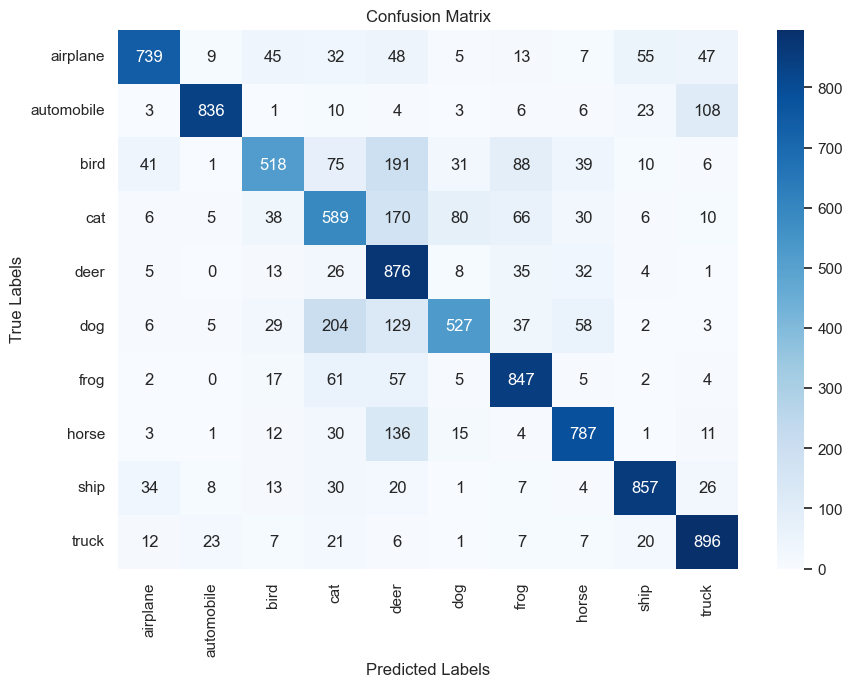

In [119]:
# Assuming `predictions` are the raw outputs from your model, e.g., softmax probabilities
# Convert predictions and true labels from one-hot encoded to class indices
best_model_predictions = np.argmax(best_model.predict(x_test), axis=-1)
y_test_indices = np.argmax(y_test, axis=-1)  # Only if y_test is one-hot encoded

sns.set_theme(style="white")
# Calculate the confusion matrix
cm = confusion_matrix(y_test_indices, best_model_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [120]:
# Assuming your model's prediction function returns the class probabilities
best_model_predictions_prob = best_model.predict(x_test)  # Get model predictions for the test set

# Convert probabilities to predicted class labels
predictions = np.argmax(best_model_predictions_prob, axis=1)

# Assuming y_test is one-hot encoded, convert it to single integer labels
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, predictions, target_names=class_names)

print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
              precision    recall  f1-score   support

    airplane       0.87      0.74      0.80      1000
  automobile       0.94      0.84      0.89      1000
        bird       0.75      0.52      0.61      1000
         cat       0.55      0.59      0.57      1000
        deer       0.54      0.88      0.66      1000
         dog       0.78      0.53      0.63      1000
        frog       0.76      0.85      0.80      1000
       horse       0.81      0.79      0.80      1000
        ship       0.87      0.86      0.87      1000
       truck       0.81      0.90      0.85      1000

    accuracy                           0.75     10000
   macro avg       0.77      0.75      0.75     10000
weighted avg       0.77      0.75      0.75     10000



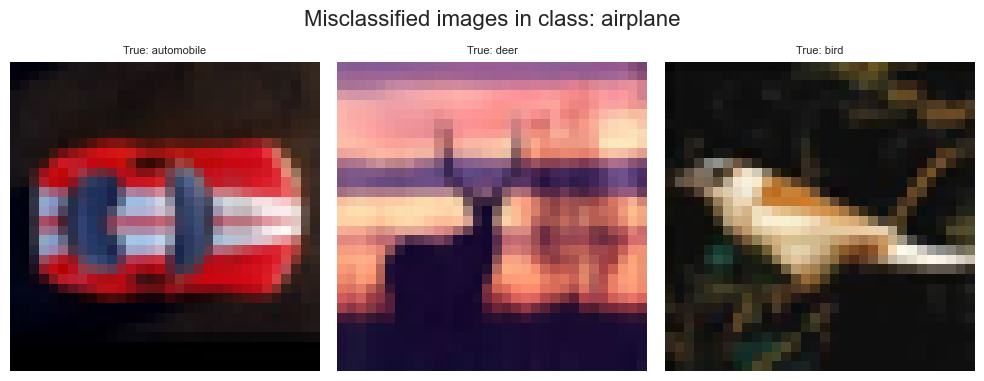

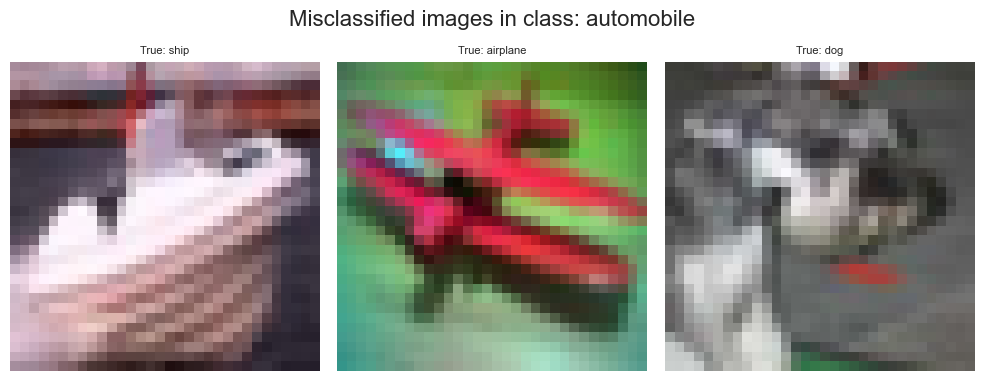

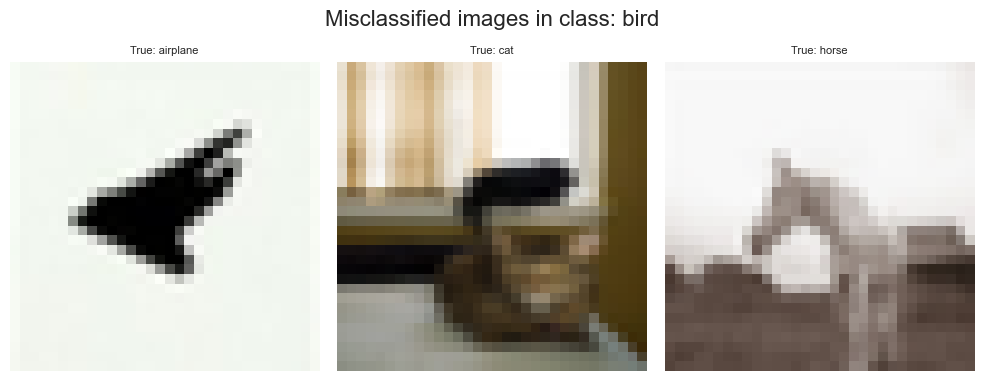

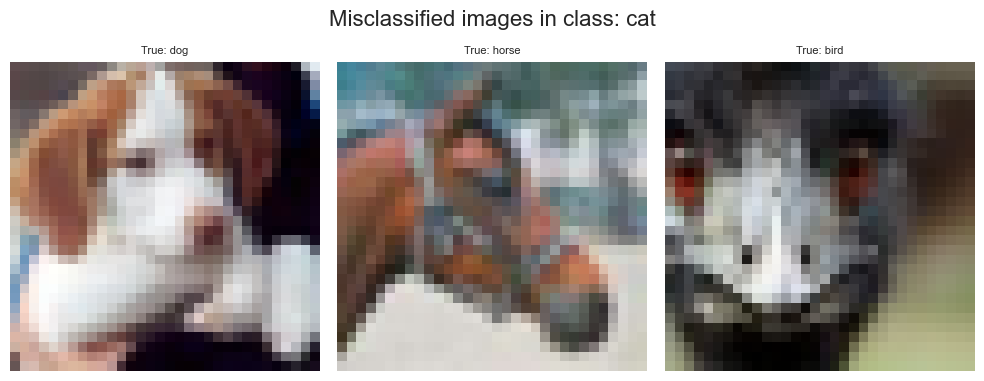

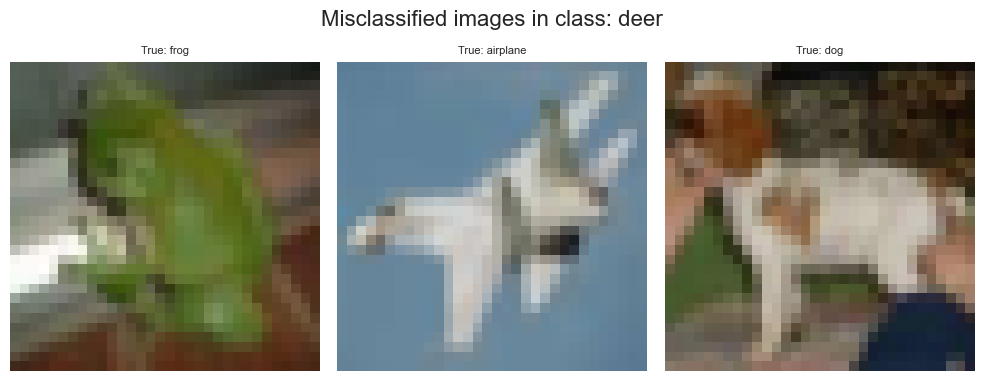

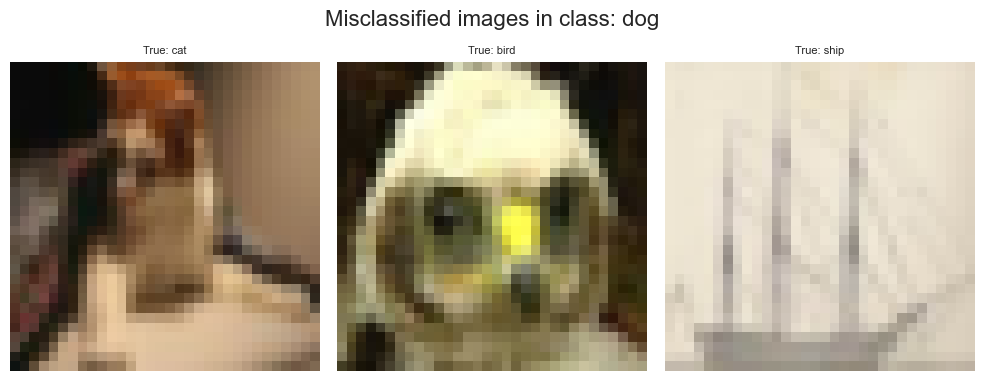

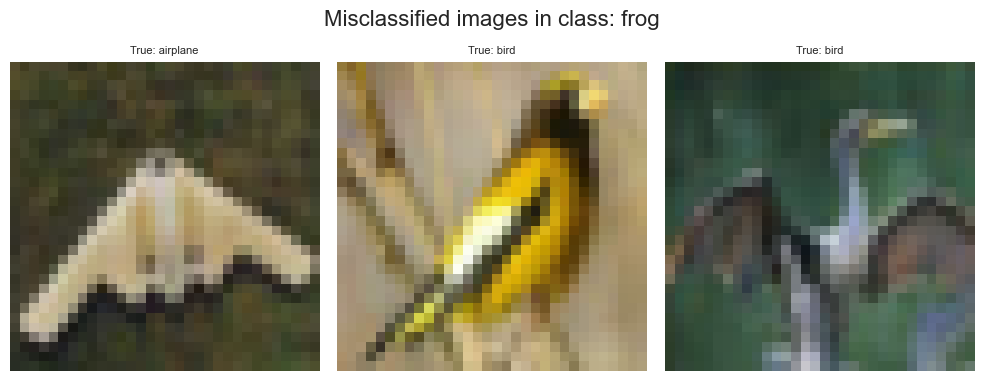

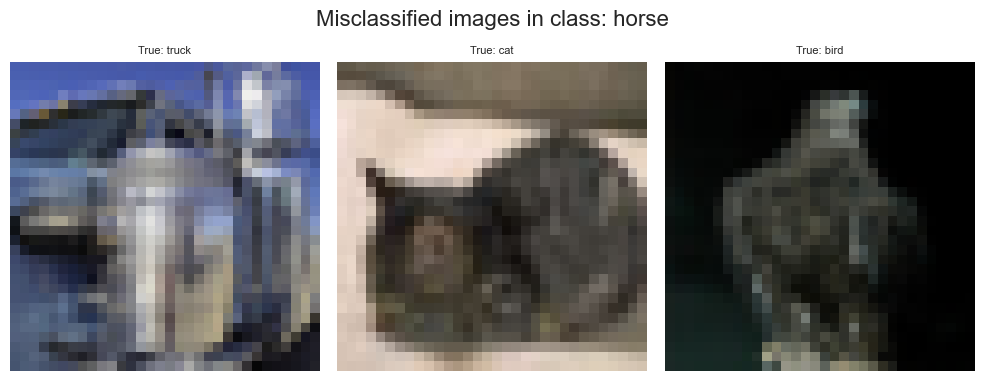

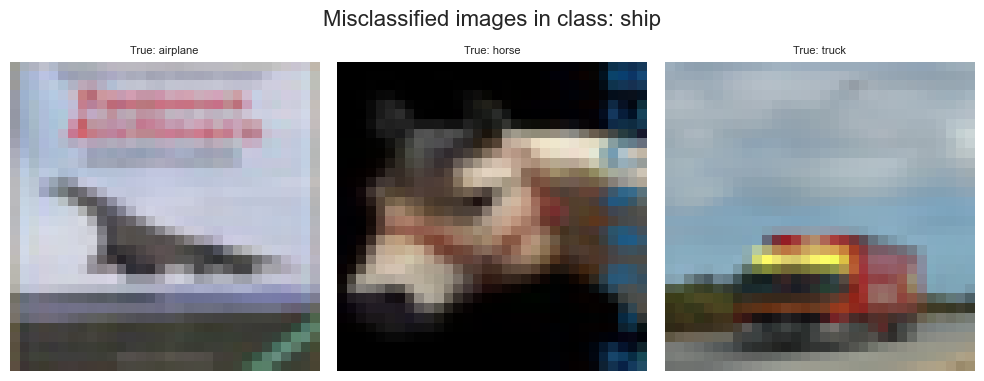

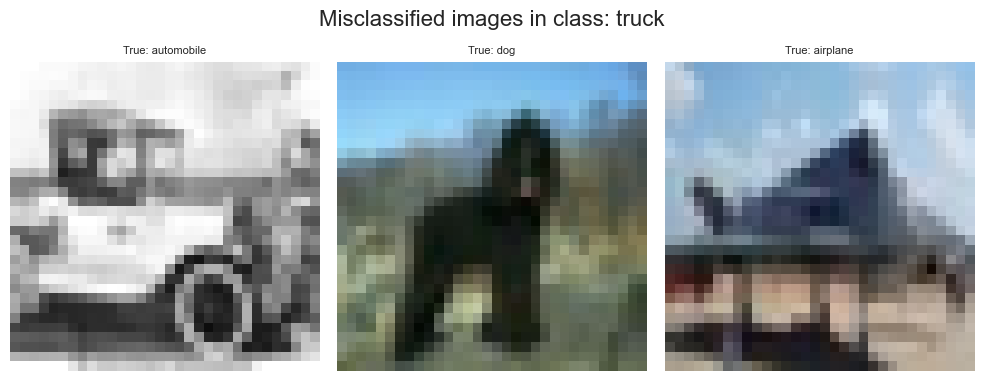

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming predictions_prob is your model's probability predictions,
# and y_test is the one-hot encoded true labels
predictions = np.argmax(best_model_predictions_prob, axis=1)
y_test_class_indices = np.argmax(y_test, axis=1)

def plot_images(images, titles, class_name, nrows=1, ncols=3):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4))
    fig.suptitle(f"Misclassified images in class: {class_name}", fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # No cmap parameter needed for color images
            ax.imshow(images[i])
            ax.set_title(titles[i], fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

for pred_class_idx, pred_class_name in enumerate(class_names):
    # Find indices where the prediction was pred_class_idx but the true class was different
    misclassified_indices = np.where((predictions == pred_class_idx) &
                                     (y_test_class_indices != pred_class_idx))[0]

    # Select a subset of misclassified images for this predicted class
    subset_indices = misclassified_indices[:3]  # Adjust the number of images as needed

    if len(subset_indices) > 0:
        images = [x_test[i].reshape(32, 32, 3) for i in subset_indices]
        titles = [f"True: {class_names[y_test_class_indices[i]]}" for i in subset_indices]

        plot_images(images, titles, pred_class_name)




In [109]:
def build_best_model():
    input_layer = Input(shape=(32, 32, 3), name='Input-BM')

    x = input_layer

    x = Conv2D(
        filters=112,
        kernel_size=(3,3),
        strides=(1,1),
        padding='same',
        dilation_rate=(1,1),
        activation='relu',
        name=f'Conv2D-BM-0'
    )(x)
    x = BatchNormalization(name=f'BatchNormalization-BM-0')(x)
    x = MaxPooling2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name=f'MaxPool2D-BM-0'
    )(x)
    x = Dropout(rate=0.2, name=f'Dropout-BM-0')(x)

    x = Conv2D(
        filters=96,
        kernel_size=(5,5),
        strides=(1,1),
        padding='same',
        dilation_rate=(1,1),
        activation='relu',
        name=f'Conv2D-BM-1',
    )(x)
    x = BatchNormalization(name=f'BatchNormalization-BM-1')(x)
    x = MaxPooling2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name=f'MaxPool2D-BM-1'
    )(x)

    x = Conv2D(
        filters=112,
        kernel_size=(3,3),
        strides=(1,1),
        padding='same',
        dilation_rate=(1,1),
        activation='relu',
        name=f'Conv2D-BM-2'
    )(x)
    x = MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2),
            padding='same',
            name=f'MaxPool2D-BM-2'
    )(x)
    x = Dropout(rate=0.1, name=f'Dropout-BM-2')(x)

    x = Conv2D(
        filters=96,
        kernel_size=(5,5),
        strides=(1,1),
        padding='same',
        dilation_rate=(1,1),
        activation='relu',
        name=f'Conv2D-BM-3',
    )(x)
    x = MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2),
            padding='same',
            name=f'MaxPool2D-BM-3'
    )(x)

    x = Conv2D(
        filters=112,
        kernel_size=(3,3),
        strides=(1,1),
        padding='same',
        dilation_rate=(1,1),
        activation='relu',
        name=f'Conv2D-BM-4'
    )(x)
    x = BatchNormalization(name=f'BatchNormalization-BM-4')(x)
    x = MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2),
            padding='same',
            name=f'MaxPool2D-BM-4'
    )(x)
    x = Dropout(rate=0.1, name=f'Dropout-BM-4')(x)




     # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)

    # It's also possible to add a configurable dense layer before the output
    x = Dense(units=64, activation='relu')(x)  # Example of a fixed pre-output dense layer

    # Define the output layer
    output_layer = Dense(units=10, activation='softmax', name='Output-BM')(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    #SGD Optimizer with learning rate 0.0001
    optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001
        )

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [117]:
epochs = 10  # Start with a small number of epochs and adjust based on your results
best_model_built = build_best_model()

best_model_built_history = best_model_built.fit(x_train, y_train, epochs=epochs, batch_size=16,initial_epoch=4,
                    validation_data=(x_val, y_val))

Epoch 5/10
 165/2813 ━━━━━━━━━━━━━━━━━━━━ 2:28 56ms/step - accuracy: 0.1126 - loss: 2.9601

KeyboardInterrupt: 

In [118]:
clean_up(best_model_built)